# Creating Subarray Images with SPyFFI
This notebook shows some of the basics of SPyFFI, using it to create images over a small subarray of the detector. Because this is rendering fewer pixels, it's probably the fastest way to test `SPyFFI` end-to-end to make sure it's working.

In [1]:
# this sets where to look for inputs and store outputs 
# (it will default to `~/.tess/spyffi` if the $SPYFFIDATA environment variable isn't set)
import os
os.environ["SPYFFIDATA"] = '/Users/zkbt/Cosmos/Data/TESS/FFIs'

In [2]:
# this makes sure that updates are actually printed to the terminal (instead of just to a log)
import logging
logging.basicConfig(level="INFO")

In [3]:
# this loads a default observation definition, which is a dictionary of dictionaries
from SPyFFI.Observation import Observation, default
inputs = default

INFO:matplotlib.font_manager:Using fontManager instance from /Users/zkbt/.matplotlib/fontList.json
INFO:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown
INFO:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


The inputs are all organized into dictionaryies within the `inputs` dictionary.

In [4]:
# how do we define the catalog of stars to use (and the light curves)
print default['catalog']

{'skykw': {'faintlimit': None, 'fast': False}, 'catalogue': 'UCAC4', 'starsarevariable': True, 'name': 'testpattern', 'lckw': {'fractionwithextremelc': 0.005, 'fractionofstarswithlc': 0.5, 'fractionwithcustom': 0.1, 'fractionwithrotation': 0.2, 'seed': 0, 'fainteststarwithlc': None, 'options': ['trapezoid', 'sin'], 'fractionwithtrapezoid': 0.3}, 'testpatternkw': {'randomizenudgesby': 21.1, 'randomizepropermotionsby': 0.0, 'spacing': 500.0, 'magnitudes': [6, 16], 'randomizemagnitudes': True}}


In [5]:
# how should exposures be created (what should be written out?)
print default['expose']

{'magnitudethreshold': 999, 'jitter': True, 'correctcosmics': True, 'smear': False, 'cosmicsdiffusion': True, 'compress': {120: True, 1800: False, 2: True, 20: True}, 'cosmicsversion': 'fancy', 'writecosmics': True, 'writesimulated': True, 'skipcosmics': False, 'writenoiseless': False, 'display': False}


In [6]:
# set up the geometry of the camera, and (importantly) the PSF library
print default['camera']

{'psfkw': {'nsubpixelsperpixel': 101, 'focus_toinclude': [0, 10], 'npixels': 21, 'noffsets_toinclude': 11, 'npositions_toinclude': 11, 'version': 'RRUasbuilt', 'stellartemp_toinclude': [4350], 'debprefix': 'woods_prf_feb2016/RAYS_ptSrc_wSi_Oct27model_AP40.6_75C_F3p314adj'}, 'focuskw': {'span': [0.0, 10.0]}, 'positionangle': 0.0, 'label': 'subarray', 'jitterkw': {'amplifyinterexposurejitter': 1.0, 'rawjitterbasename': 'cartoon.jitter', 'jitterrms': None}, 'stamps': {120: None, 1800: None, 2: None, 20: None}, 'variablefocus': False, 'counterstep': 1, 'warpspaceandtime': False, 'subarray': 200, 'dec': 66.56070833333332, 'roll': 0, 'cadence': 1800, 'ra': 270.0}


In [7]:
# in what ways should we jitter the motion of the camera?
print default['jitter']

{'amplifyinterexposurejitter': 1.0, 'rawjitterbasename': 'cartoon.jitter', 'jitterrms': None}


In [8]:
# how many of each exposure time should we create (and in what order?)
print default['observation']

{'cadencestodo': {2: 100}, 'collate': True}


Let's modify some of those input options, by changing values associated with some of the directory keys inside each sub-group.

In [9]:
# give a label to this observation (that goes into the directory name)
inputs['camera']['label'] = 'manycosmics'
# how big of a subarray in pixels (centered on the FOV); None will give four normal CCDs
inputs['camera']['subarray'] = 200
# should we change the focus throughout the orbit? 
inputs['camera']['variablefocus'] = False

# should we skip injecting cosmic rays? (False = *do* inject cosmics)
inputs['expose']['skipcosmics'] = False
# let's write the cosmic ray images out as separate files
inputs['expose']['writecosmics'] = True

# what's the catalog ("testpattern" or "UCAC4")
inputs['catalog']['name'] = 'testpattern'
# should we randomize the magnitudes of the stars
inputs['catalog']['testpatternkw']['randomizemagnitudes'] = True
# what range of magnitudes should the stars span?
inputs['catalog']['testpatternkw']['magnitudes'] = [6,16]

# how many of each exposure duration should we make?
inputs['observation']['cadencestodo'] = {2:100}
o = Observation(inputs)

INFO:SPyFFI.Observation:  creating a new observation, with the following inputs:
INFO:SPyFFI.Observation:      inputs[expose] = 
INFO:SPyFFI.Observation:                 magnitudethreshold:999
INFO:SPyFFI.Observation:                             jitter:True
INFO:SPyFFI.Observation:                     correctcosmics:True
INFO:SPyFFI.Observation:                              smear:False
INFO:SPyFFI.Observation:                   cosmicsdiffusion:True
INFO:SPyFFI.Observation:                           compress:{120: True, 1800: False, 2: True, 20: True}
INFO:SPyFFI.Observation:                     cosmicsversion:fancy
INFO:SPyFFI.Observation:                       writecosmics:True
INFO:SPyFFI.Observation:                     writesimulated:True
INFO:SPyFFI.Observation:                        skipcosmics:False
INFO:SPyFFI.Observation:                     writenoiseless:False
INFO:SPyFFI.Observation:                            display:False
INFO:SPyFFI.Observation:      inputs[camera] = 


In [11]:
# generate some light curves to populate the catalog
import SPyFFI.Lightcurve as lc, numpy as np

# every star in the catalog has a light curve; we can modify them one-by-one
for i in range(len(o.camera.catalog.ra)):
    o.camera.catalog.lightcurves[i] = lc.constant()

# we can convert the catalog RA + Dec to x, y
ra, dec = o.camera.catalog.ra, o.camera.catalog.dec
coord = o.camera.cartographer.point(ra, dec, 'celestial')
x, y = coord.ccdxy.tuple

# let's pick one bright star that's on the detector...
n = o.camera.ccds[0].xsize
ok = (x > 0)*(x < n)*(y < n)*(y > 0)
ok *= (o.camera.catalog.tmag < 11.0)
lucky = np.random.choice(np.nonzero(ok)[0], 1)[0]

# ... and inject a deep transit into it
o.camera.catalog.lightcurves[lucky] = lc.Trapezoid(P=0.3, 
                                                   E=2457827.0 + 0.15, 
                                                   D=1.0, 
                                                   T23=0.00, 
                                                   T14=0.1)

In [12]:
# let's print out the locations and light curves of the stars
for i, l in enumerate(o.camera.catalog.lightcurves):
    print '{:>5} = ({:5.1f},{:5.1f}) = {}'.format(i,x[i],y[i],l)

    0 = (289.0,-85.8) = <constant()>
    1 = (265.5,-86.7) = <constant()>
    2 = (241.7,-87.6) = <constant()>
    3 = (218.1,-88.4) = <constant()>
    4 = (194.3,-89.0) = <constant()>
    5 = (170.7,-89.8) = <constant()>
    6 = (146.8,-89.6) = <constant()>
    7 = (123.2,-89.9) = <constant()>
    8 = ( 99.6,-90.5) = <constant()>
    9 = ( 75.9,-90.2) = <constant()>
   10 = ( 52.2,-89.4) = <constant()>
   11 = ( 28.5,-89.2) = <constant()>
   12 = (  4.6,-89.0) = <constant()>
   13 = (-18.9,-88.9) = <constant()>
   14 = (-42.7,-87.9) = <constant()>
   15 = (-66.5,-87.4) = <constant()>
   16 = (-90.1,-85.8) = <constant()>
   17 = (289.0,-62.0) = <constant()>
   18 = (265.4,-62.9) = <constant()>
   19 = (241.7,-64.4) = <constant()>
   20 = (218.0,-65.2) = <constant()>
   21 = (194.2,-65.5) = <constant()>
   22 = (170.6,-65.4) = <constant()>
   23 = (146.9,-65.8) = <constant()>
   24 = (123.3,-66.0) = <constant()>
   25 = ( 99.5,-65.9) = <constant()>
   26 = ( 75.7,-66.4) = <constant()>
 

INFO:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


<Trapezoid(T14=0.1,P=0.3,T23=0.0,E=2457827.15,D=1.0)>


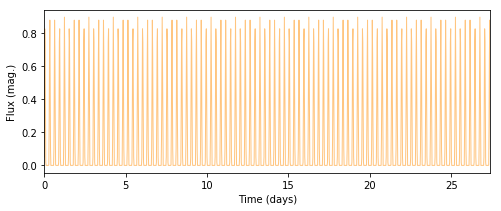

In [13]:
# let's plot the light curve of that one lucky star
%matplotlib inline 
l = o.camera.catalog.lightcurves[lucky]
l.demo()
print l

In [ ]:
o.create()

INFO:SPyFFI.Camera:setting cadence to 2 seconds = 1 reads.
INFO:SPyFFI.Jitter:populating the jitterball for 2 second cadence, based on the raw jitter file cartoon.jitter.cadence2s.unscaled.
INFO:SPyFFI.PSF:initializing PSF painter, based on woods_prf_feb2016/RAYS_ptSrc_wSi_Oct27model_AP40.6_75C_F3p314adj
INFO:SPyFFI.Intrapixel:creating an intrapixel sensitivity map called perfectpixels
INFO:SPyFFI.PSF:setting up the pixel arrays
INFO:SPyFFI.PSF:created pixel coordinate arrays
INFO:SPyFFI.CCD:created CCD #1, of size 21x21
INFO:SPyFFI.PSF:trying to load PSFs from /Users/zkbt/Cosmos/Data/TESS/FFIs/intermediates/psfs/RRUasbuilt/focus0and10_stellartemp4350/pixelizedlibrary_cartoon.jitter.cadence2s.unscaled_perfectpixels_11positions_11offsets.npy
INFO:SPyFFI.PSF:...success!
INFO:SPyFFI.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:SPyFFI.Catalogs:save projected star catalog /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_manycosmics/2s/sub200x200/catalog_testpatt

INFO:SPyFFI.CCD:adding read noise
INFO:SPyFFI.CCD:    = quadrature sum of 1 reads with 10.0 e- each.
INFO:SPyFFI.CCD:saving simulated exposure 2 for sub200x200
INFO:SPyFFI.CCD:saving 200x200 image with type int32 to
INFO:SPyFFI.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_manycosmics/2s/sub200x200/simulated_testpattern_6to16_sub200x200_000002.fits
INFO:SPyFFI.CCD:created image #0000002 of testpattern with 2s cadence
INFO:SPyFFI.Jitter:updated header keywords
INFO:SPyFFI.Jitter:nudged the camera to -0.347995509891,-0.822097144165 away from nominal pointing.
INFO:SPyFFI.CCD:projecting the starmap onto CCD
INFO:SPyFFI.CCD:taking a snapshot at 2457827.00007 = 2017.20054776
INFO:SPyFFI.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:SPyFFI.CCD:  done!
INFO:SPyFFI.CCD:skipping differental velocity aberration
INFO:SPyFFI.CCD:adding 81 stars between 6.0 and 15.8 magnitudes
INFO:SPyFFI.CCD:the camera's focus is set to 0.0
INFO:SPyFFI.CCD:adding backgrounds
IN

INFO:SPyFFI.CCD:adding read noise
INFO:SPyFFI.CCD:    = quadrature sum of 1 reads with 10.0 e- each.
INFO:SPyFFI.CCD:saving simulated exposure 6 for sub200x200
INFO:SPyFFI.CCD:saving 200x200 image with type int32 to
INFO:SPyFFI.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_manycosmics/2s/sub200x200/simulated_testpattern_6to16_sub200x200_000006.fits
INFO:SPyFFI.CCD:created image #0000006 of testpattern with 2s cadence
INFO:SPyFFI.Jitter:updated header keywords
INFO:SPyFFI.Jitter:nudged the camera to -0.0868506376949,-0.0686064193579 away from nominal pointing.
INFO:SPyFFI.CCD:projecting the starmap onto CCD
INFO:SPyFFI.CCD:taking a snapshot at 2457827.00016 = 2017.20054801
INFO:SPyFFI.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:SPyFFI.CCD:  done!
INFO:SPyFFI.CCD:skipping differental velocity aberration
INFO:SPyFFI.CCD:adding 81 stars between 6.0 and 15.8 magnitudes
INFO:SPyFFI.CCD:the camera's focus is set to 0.0
INFO:SPyFFI.CCD:adding backgrounds


INFO:SPyFFI.CCD:adding read noise
INFO:SPyFFI.CCD:    = quadrature sum of 1 reads with 10.0 e- each.
INFO:SPyFFI.CCD:saving simulated exposure 10 for sub200x200
INFO:SPyFFI.CCD:saving 200x200 image with type int32 to
INFO:SPyFFI.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_manycosmics/2s/sub200x200/simulated_testpattern_6to16_sub200x200_000010.fits
INFO:SPyFFI.CCD:created image #0000010 of testpattern with 2s cadence
INFO:SPyFFI.Jitter:updated header keywords
INFO:SPyFFI.Jitter:nudged the camera to -0.338723349265,-0.120698020918 away from nominal pointing.
INFO:SPyFFI.CCD:projecting the starmap onto CCD
INFO:SPyFFI.CCD:taking a snapshot at 2457827.00025 = 2017.20054827
INFO:SPyFFI.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:SPyFFI.CCD:  done!
INFO:SPyFFI.CCD:skipping differental velocity aberration
INFO:SPyFFI.CCD:adding 81 stars between 6.0 and 15.8 magnitudes
INFO:SPyFFI.CCD:the camera's focus is set to 0.0
INFO:SPyFFI.CCD:adding backgrounds
I

INFO:SPyFFI.CCD:adding read noise
INFO:SPyFFI.CCD:    = quadrature sum of 1 reads with 10.0 e- each.
INFO:SPyFFI.CCD:saving simulated exposure 14 for sub200x200
INFO:SPyFFI.CCD:saving 200x200 image with type int32 to
INFO:SPyFFI.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_manycosmics/2s/sub200x200/simulated_testpattern_6to16_sub200x200_000014.fits
INFO:SPyFFI.CCD:created image #0000014 of testpattern with 2s cadence
INFO:SPyFFI.Jitter:updated header keywords
INFO:SPyFFI.Jitter:nudged the camera to -0.383801176516,-0.679840272935 away from nominal pointing.
INFO:SPyFFI.CCD:projecting the starmap onto CCD
INFO:SPyFFI.CCD:taking a snapshot at 2457827.00035 = 2017.20054852
INFO:SPyFFI.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:SPyFFI.CCD:  done!
INFO:SPyFFI.CCD:skipping differental velocity aberration
INFO:SPyFFI.CCD:adding 81 stars between 6.0 and 15.8 magnitudes
INFO:SPyFFI.CCD:the camera's focus is set to 0.0
INFO:SPyFFI.CCD:adding backgrounds
I

INFO:SPyFFI.CCD:adding read noise
INFO:SPyFFI.CCD:    = quadrature sum of 1 reads with 10.0 e- each.
INFO:SPyFFI.CCD:saving simulated exposure 18 for sub200x200
INFO:SPyFFI.CCD:saving 200x200 image with type int32 to
INFO:SPyFFI.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_manycosmics/2s/sub200x200/simulated_testpattern_6to16_sub200x200_000018.fits
INFO:SPyFFI.CCD:created image #0000018 of testpattern with 2s cadence
INFO:SPyFFI.Jitter:updated header keywords
INFO:SPyFFI.Jitter:nudged the camera to 0.0168141466131,-0.0305841332106 away from nominal pointing.
INFO:SPyFFI.CCD:projecting the starmap onto CCD
INFO:SPyFFI.CCD:taking a snapshot at 2457827.00044 = 2017.20054877
INFO:SPyFFI.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:SPyFFI.CCD:  done!
INFO:SPyFFI.CCD:skipping differental velocity aberration
INFO:SPyFFI.CCD:adding 81 stars between 6.0 and 15.8 magnitudes
INFO:SPyFFI.CCD:the camera's focus is set to 0.0
INFO:SPyFFI.CCD:adding backgrounds


INFO:SPyFFI.CCD:adding read noise
INFO:SPyFFI.CCD:    = quadrature sum of 1 reads with 10.0 e- each.
INFO:SPyFFI.CCD:saving simulated exposure 22 for sub200x200
INFO:SPyFFI.CCD:saving 200x200 image with type int32 to
INFO:SPyFFI.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_manycosmics/2s/sub200x200/simulated_testpattern_6to16_sub200x200_000022.fits
INFO:SPyFFI.CCD:created image #0000022 of testpattern with 2s cadence
INFO:SPyFFI.Jitter:updated header keywords
INFO:SPyFFI.Jitter:nudged the camera to 0.424794366614,0.636445149011 away from nominal pointing.
INFO:SPyFFI.CCD:projecting the starmap onto CCD
INFO:SPyFFI.CCD:taking a snapshot at 2457827.00053 = 2017.20054903
INFO:SPyFFI.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:SPyFFI.CCD:  done!
INFO:SPyFFI.CCD:skipping differental velocity aberration
INFO:SPyFFI.CCD:adding 81 stars between 6.0 and 15.8 magnitudes
INFO:SPyFFI.CCD:the camera's focus is set to 0.0
INFO:SPyFFI.CCD:adding backgrounds
INF

INFO:SPyFFI.CCD:adding read noise
INFO:SPyFFI.CCD:    = quadrature sum of 1 reads with 10.0 e- each.
INFO:SPyFFI.CCD:saving simulated exposure 26 for sub200x200
INFO:SPyFFI.CCD:saving 200x200 image with type int32 to
INFO:SPyFFI.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_manycosmics/2s/sub200x200/simulated_testpattern_6to16_sub200x200_000026.fits
INFO:SPyFFI.CCD:created image #0000026 of testpattern with 2s cadence
INFO:SPyFFI.Jitter:updated header keywords
INFO:SPyFFI.Jitter:nudged the camera to -0.317218492703,0.95001758419 away from nominal pointing.
INFO:SPyFFI.CCD:projecting the starmap onto CCD
INFO:SPyFFI.CCD:taking a snapshot at 2457827.00062 = 2017.20054928
INFO:SPyFFI.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:SPyFFI.CCD:  done!
INFO:SPyFFI.CCD:skipping differental velocity aberration
INFO:SPyFFI.CCD:adding 81 stars between 6.0 and 15.8 magnitudes
INFO:SPyFFI.CCD:the camera's focus is set to 0.0
INFO:SPyFFI.CCD:adding backgrounds
INF

INFO:SPyFFI.CCD:adding read noise
INFO:SPyFFI.CCD:    = quadrature sum of 1 reads with 10.0 e- each.
INFO:SPyFFI.CCD:saving simulated exposure 30 for sub200x200
INFO:SPyFFI.CCD:saving 200x200 image with type int32 to
INFO:SPyFFI.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_manycosmics/2s/sub200x200/simulated_testpattern_6to16_sub200x200_000030.fits
INFO:SPyFFI.CCD:created image #0000030 of testpattern with 2s cadence
INFO:SPyFFI.Jitter:updated header keywords
INFO:SPyFFI.Jitter:nudged the camera to -0.578115755637,0.412280874704 away from nominal pointing.
INFO:SPyFFI.CCD:projecting the starmap onto CCD
INFO:SPyFFI.CCD:taking a snapshot at 2457827.00072 = 2017.20054953
INFO:SPyFFI.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:SPyFFI.CCD:  done!
INFO:SPyFFI.CCD:skipping differental velocity aberration
INFO:SPyFFI.CCD:adding 81 stars between 6.0 and 15.8 magnitudes
INFO:SPyFFI.CCD:the camera's focus is set to 0.0
INFO:SPyFFI.CCD:adding backgrounds
IN

INFO:SPyFFI.CCD:adding read noise
INFO:SPyFFI.CCD:    = quadrature sum of 1 reads with 10.0 e- each.
INFO:SPyFFI.CCD:saving simulated exposure 34 for sub200x200
INFO:SPyFFI.CCD:saving 200x200 image with type int32 to
INFO:SPyFFI.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_manycosmics/2s/sub200x200/simulated_testpattern_6to16_sub200x200_000034.fits
INFO:SPyFFI.CCD:created image #0000034 of testpattern with 2s cadence
INFO:SPyFFI.Jitter:updated header keywords
INFO:SPyFFI.Jitter:nudged the camera to -0.347006289316,-0.0668549099509 away from nominal pointing.
INFO:SPyFFI.CCD:projecting the starmap onto CCD
INFO:SPyFFI.CCD:taking a snapshot at 2457827.00081 = 2017.20054979
INFO:SPyFFI.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:SPyFFI.CCD:  done!
INFO:SPyFFI.CCD:skipping differental velocity aberration
INFO:SPyFFI.CCD:adding 81 stars between 6.0 and 15.8 magnitudes
INFO:SPyFFI.CCD:the camera's focus is set to 0.0
INFO:SPyFFI.CCD:adding backgrounds


INFO:SPyFFI.CCD:adding read noise
INFO:SPyFFI.CCD:    = quadrature sum of 1 reads with 10.0 e- each.
INFO:SPyFFI.CCD:saving simulated exposure 38 for sub200x200
INFO:SPyFFI.CCD:saving 200x200 image with type int32 to
INFO:SPyFFI.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_manycosmics/2s/sub200x200/simulated_testpattern_6to16_sub200x200_000038.fits
INFO:SPyFFI.CCD:created image #0000038 of testpattern with 2s cadence
INFO:SPyFFI.Jitter:updated header keywords
INFO:SPyFFI.Jitter:nudged the camera to 0.28482832572,-0.246017795523 away from nominal pointing.
INFO:SPyFFI.CCD:projecting the starmap onto CCD
INFO:SPyFFI.CCD:taking a snapshot at 2457827.0009 = 2017.20055004
INFO:SPyFFI.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:SPyFFI.CCD:  done!
INFO:SPyFFI.CCD:skipping differental velocity aberration
INFO:SPyFFI.CCD:adding 81 stars between 6.0 and 15.8 magnitudes
INFO:SPyFFI.CCD:the camera's focus is set to 0.0
INFO:SPyFFI.CCD:adding backgrounds
INFO

INFO:SPyFFI.CCD:adding read noise
INFO:SPyFFI.CCD:    = quadrature sum of 1 reads with 10.0 e- each.
INFO:SPyFFI.CCD:saving simulated exposure 42 for sub200x200
INFO:SPyFFI.CCD:saving 200x200 image with type int32 to
INFO:SPyFFI.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_manycosmics/2s/sub200x200/simulated_testpattern_6to16_sub200x200_000042.fits
INFO:SPyFFI.CCD:created image #0000042 of testpattern with 2s cadence
INFO:SPyFFI.Jitter:updated header keywords
INFO:SPyFFI.Jitter:nudged the camera to 0.201327191368,-0.61586488958 away from nominal pointing.
INFO:SPyFFI.CCD:projecting the starmap onto CCD
INFO:SPyFFI.CCD:taking a snapshot at 2457827.001 = 2017.2005503
INFO:SPyFFI.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:SPyFFI.CCD:  done!
INFO:SPyFFI.CCD:skipping differental velocity aberration
INFO:SPyFFI.CCD:adding 81 stars between 6.0 and 15.8 magnitudes
INFO:SPyFFI.CCD:the camera's focus is set to 0.0
INFO:SPyFFI.CCD:adding backgrounds
INFO:S

INFO:SPyFFI.CCD:adding read noise
INFO:SPyFFI.CCD:    = quadrature sum of 1 reads with 10.0 e- each.
INFO:SPyFFI.CCD:saving simulated exposure 46 for sub200x200
INFO:SPyFFI.CCD:saving 200x200 image with type int32 to
INFO:SPyFFI.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_manycosmics/2s/sub200x200/simulated_testpattern_6to16_sub200x200_000046.fits
INFO:SPyFFI.CCD:created image #0000046 of testpattern with 2s cadence
INFO:SPyFFI.Jitter:updated header keywords
INFO:SPyFFI.Jitter:nudged the camera to 0.702633006086,-0.56350478553 away from nominal pointing.
INFO:SPyFFI.CCD:projecting the starmap onto CCD
INFO:SPyFFI.CCD:taking a snapshot at 2457827.00109 = 2017.20055055
INFO:SPyFFI.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:SPyFFI.CCD:  done!
INFO:SPyFFI.CCD:skipping differental velocity aberration
INFO:SPyFFI.CCD:adding 81 stars between 6.0 and 15.8 magnitudes
INFO:SPyFFI.CCD:the camera's focus is set to 0.0
INFO:SPyFFI.CCD:adding backgrounds
INF

INFO:SPyFFI.CCD:adding read noise
INFO:SPyFFI.CCD:    = quadrature sum of 1 reads with 10.0 e- each.
INFO:SPyFFI.CCD:saving simulated exposure 50 for sub200x200
INFO:SPyFFI.CCD:saving 200x200 image with type int32 to
INFO:SPyFFI.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_manycosmics/2s/sub200x200/simulated_testpattern_6to16_sub200x200_000050.fits
INFO:SPyFFI.CCD:created image #0000050 of testpattern with 2s cadence
INFO:SPyFFI.Jitter:updated header keywords
INFO:SPyFFI.Jitter:nudged the camera to -0.0938293024732,0.0456099728372 away from nominal pointing.
INFO:SPyFFI.CCD:projecting the starmap onto CCD
INFO:SPyFFI.CCD:taking a snapshot at 2457827.00118 = 2017.2005508
INFO:SPyFFI.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:SPyFFI.CCD:  done!
INFO:SPyFFI.CCD:skipping differental velocity aberration
INFO:SPyFFI.CCD:adding 81 stars between 6.0 and 15.8 magnitudes
INFO:SPyFFI.CCD:the camera's focus is set to 0.0
INFO:SPyFFI.CCD:adding backgrounds
I

INFO:SPyFFI.CCD:adding read noise
INFO:SPyFFI.CCD:    = quadrature sum of 1 reads with 10.0 e- each.
INFO:SPyFFI.CCD:saving simulated exposure 54 for sub200x200
INFO:SPyFFI.CCD:saving 200x200 image with type int32 to
INFO:SPyFFI.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_manycosmics/2s/sub200x200/simulated_testpattern_6to16_sub200x200_000054.fits
INFO:SPyFFI.CCD:created image #0000054 of testpattern with 2s cadence
INFO:SPyFFI.Jitter:updated header keywords
INFO:SPyFFI.Jitter:nudged the camera to 0.307600193542,0.163068470347 away from nominal pointing.
INFO:SPyFFI.CCD:projecting the starmap onto CCD
INFO:SPyFFI.CCD:taking a snapshot at 2457827.00127 = 2017.20055106
INFO:SPyFFI.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:SPyFFI.CCD:  done!
INFO:SPyFFI.CCD:skipping differental velocity aberration
INFO:SPyFFI.CCD:adding 81 stars between 6.0 and 15.8 magnitudes
INFO:SPyFFI.CCD:the camera's focus is set to 0.0
INFO:SPyFFI.CCD:adding backgrounds
INF

INFO:SPyFFI.CCD:adding read noise
INFO:SPyFFI.CCD:    = quadrature sum of 1 reads with 10.0 e- each.
INFO:SPyFFI.CCD:saving simulated exposure 58 for sub200x200
INFO:SPyFFI.CCD:saving 200x200 image with type int32 to
INFO:SPyFFI.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_manycosmics/2s/sub200x200/simulated_testpattern_6to16_sub200x200_000058.fits
INFO:SPyFFI.CCD:created image #0000058 of testpattern with 2s cadence
INFO:SPyFFI.Jitter:updated header keywords
INFO:SPyFFI.Jitter:nudged the camera to 0.618938120816,-0.0794483026124 away from nominal pointing.
INFO:SPyFFI.CCD:projecting the starmap onto CCD
INFO:SPyFFI.CCD:taking a snapshot at 2457827.00137 = 2017.20055131
INFO:SPyFFI.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:SPyFFI.CCD:  done!
INFO:SPyFFI.CCD:skipping differental velocity aberration
INFO:SPyFFI.CCD:adding 81 stars between 6.0 and 15.8 magnitudes
INFO:SPyFFI.CCD:the camera's focus is set to 0.0
INFO:SPyFFI.CCD:adding backgrounds
I

INFO:SPyFFI.CCD:adding read noise
INFO:SPyFFI.CCD:    = quadrature sum of 1 reads with 10.0 e- each.
INFO:SPyFFI.CCD:saving simulated exposure 62 for sub200x200
INFO:SPyFFI.CCD:saving 200x200 image with type int32 to
INFO:SPyFFI.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_manycosmics/2s/sub200x200/simulated_testpattern_6to16_sub200x200_000062.fits
INFO:SPyFFI.CCD:created image #0000062 of testpattern with 2s cadence
INFO:SPyFFI.Jitter:updated header keywords
INFO:SPyFFI.Jitter:nudged the camera to 0.470973631277,-0.337723299155 away from nominal pointing.
INFO:SPyFFI.CCD:projecting the starmap onto CCD
INFO:SPyFFI.CCD:taking a snapshot at 2457827.00146 = 2017.20055156
INFO:SPyFFI.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:SPyFFI.CCD:  done!
INFO:SPyFFI.CCD:skipping differental velocity aberration
INFO:SPyFFI.CCD:adding 81 stars between 6.0 and 15.8 magnitudes
INFO:SPyFFI.CCD:the camera's focus is set to 0.0
INFO:SPyFFI.CCD:adding backgrounds
IN

INFO:SPyFFI.CCD:adding read noise
INFO:SPyFFI.CCD:    = quadrature sum of 1 reads with 10.0 e- each.
INFO:SPyFFI.CCD:saving simulated exposure 66 for sub200x200
INFO:SPyFFI.CCD:saving 200x200 image with type int32 to
INFO:SPyFFI.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_manycosmics/2s/sub200x200/simulated_testpattern_6to16_sub200x200_000066.fits
INFO:SPyFFI.CCD:created image #0000066 of testpattern with 2s cadence
INFO:SPyFFI.Jitter:updated header keywords
INFO:SPyFFI.Jitter:nudged the camera to 0.703124448179,0.282661344606 away from nominal pointing.
INFO:SPyFFI.CCD:projecting the starmap onto CCD
INFO:SPyFFI.CCD:taking a snapshot at 2457827.00155 = 2017.20055182
INFO:SPyFFI.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:SPyFFI.CCD:  done!
INFO:SPyFFI.CCD:skipping differental velocity aberration
INFO:SPyFFI.CCD:adding 81 stars between 6.0 and 15.8 magnitudes
INFO:SPyFFI.CCD:the camera's focus is set to 0.0
INFO:SPyFFI.CCD:adding backgrounds
INF

INFO:SPyFFI.CCD:adding read noise
INFO:SPyFFI.CCD:    = quadrature sum of 1 reads with 10.0 e- each.
INFO:SPyFFI.CCD:saving simulated exposure 70 for sub200x200
INFO:SPyFFI.CCD:saving 200x200 image with type int32 to
INFO:SPyFFI.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_manycosmics/2s/sub200x200/simulated_testpattern_6to16_sub200x200_000070.fits
INFO:SPyFFI.CCD:created image #0000070 of testpattern with 2s cadence
INFO:SPyFFI.Jitter:updated header keywords
INFO:SPyFFI.Jitter:nudged the camera to -0.242502716675,0.362172433289 away from nominal pointing.
INFO:SPyFFI.CCD:projecting the starmap onto CCD
INFO:SPyFFI.CCD:taking a snapshot at 2457827.00164 = 2017.20055207
INFO:SPyFFI.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:SPyFFI.CCD:  done!
INFO:SPyFFI.CCD:skipping differental velocity aberration
INFO:SPyFFI.CCD:adding 81 stars between 6.0 and 15.8 magnitudes
INFO:SPyFFI.CCD:the camera's focus is set to 0.0
INFO:SPyFFI.CCD:adding backgrounds
IN

INFO:SPyFFI.CCD:adding read noise
INFO:SPyFFI.CCD:    = quadrature sum of 1 reads with 10.0 e- each.
INFO:SPyFFI.CCD:saving simulated exposure 74 for sub200x200
INFO:SPyFFI.CCD:saving 200x200 image with type int32 to
INFO:SPyFFI.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_manycosmics/2s/sub200x200/simulated_testpattern_6to16_sub200x200_000074.fits
INFO:SPyFFI.CCD:created image #0000074 of testpattern with 2s cadence
INFO:SPyFFI.Jitter:updated header keywords
INFO:SPyFFI.Jitter:nudged the camera to -0.201693935158,0.300853144085 away from nominal pointing.
INFO:SPyFFI.CCD:projecting the starmap onto CCD
INFO:SPyFFI.CCD:taking a snapshot at 2457827.00174 = 2017.20055232
INFO:SPyFFI.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:SPyFFI.CCD:  done!
INFO:SPyFFI.CCD:skipping differental velocity aberration
INFO:SPyFFI.CCD:adding 81 stars between 6.0 and 15.8 magnitudes
INFO:SPyFFI.CCD:the camera's focus is set to 0.0
INFO:SPyFFI.CCD:adding backgrounds
IN

INFO:SPyFFI.CCD:adding read noise
INFO:SPyFFI.CCD:    = quadrature sum of 1 reads with 10.0 e- each.
INFO:SPyFFI.CCD:saving simulated exposure 78 for sub200x200
INFO:SPyFFI.CCD:saving 200x200 image with type int32 to
INFO:SPyFFI.CCD:  /Users/zkbt/Cosmos/Data/TESS/FFIs/outputs/testpattern_6to16_manycosmics/2s/sub200x200/simulated_testpattern_6to16_sub200x200_000078.fits
INFO:SPyFFI.CCD:created image #0000078 of testpattern with 2s cadence
INFO:SPyFFI.Jitter:updated header keywords
INFO:SPyFFI.Jitter:nudged the camera to 0.197632348227,-0.637863363444 away from nominal pointing.
INFO:SPyFFI.CCD:projecting the starmap onto CCD
INFO:SPyFFI.CCD:taking a snapshot at 2457827.00183 = 2017.20055258
INFO:SPyFFI.Catalogs:projecting catalog -0.799 years relative to 2018
INFO:SPyFFI.CCD:  done!
INFO:SPyFFI.CCD:skipping differental velocity aberration
INFO:SPyFFI.CCD:adding 81 stars between 6.0 and 15.8 magnitudes
INFO:SPyFFI.CCD:the camera's focus is set to 0.0
INFO:SPyFFI.CCD:adding backgrounds
IN

This should now take a while (like a few minutes?) to create a bunch of images and drop them in `$SPYFFIDATA/testpattern_6to16_transit/1800s/sub200x200/`. Go check them out and see what's what!